In [2]:
#%matplotlib qt
%matplotlib inline

In [260]:
import pandas as pd
import numpy as np
import scipy.stats as st
from ggplot import *
import datetime
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [4]:
turnstile_weather = pd.read_csv('./improved-dataset/turnstile_weather_v2.csv')

In [5]:
turnstile_weather['DAYn'] = turnstile_weather.datetime.map(lambda x: pd.to_datetime(x).day)

In [6]:
def normalize_features(df):
    
    mu = df.mean()
    sigma = df.std()
    
    if (sigma == 0).any():
        raise Exception("One or more features had the same value for all samples, and thus could " + \
                         "not be normalized. Please do not include features with only a single value " + \
                         "in your model.")
    df_normalized = (df - df.mean()) / df.std()

    return df_normalized, mu, sigma

In [7]:
def compute_cost(features, values, theta):
    
    x = features
    y = values
    m = len(y)
    
    y_predicted = np.dot(x, theta)
    e = y - y_predicted
    cost = np.sum(np.power(e, 2))/(2*m)

    return cost

In [92]:
def gradient_descent(features, values, theta, alpha, num_iterations):
    
    x = features
    y = values
    
    m = len(values)
    cost_history = []

    for i in range(num_iterations):
        y_predicted = np.dot(x, theta)
        e = y - y_predicted
        theta += np.dot(e, x) / m * alpha
        cost_history.append(compute_cost(features, values, theta))
    
    return theta, pd.Series(cost_history)

In [16]:
def ols_function(y, x):
    x = sm.add_constant(x)
    model = sm.OLS(y, x)
    fit = model.fit()
    
    return fit

In [324]:
# Select Features (try different features!)
features = turnstile_weather[['hour', 'day_week', 'weekday', 'fog', 'precipi', 'pressurei', 'rain', 'tempi', 'wspdi']]

# Add UNIT to features using dummy variables
dummy_units = pd.get_dummies(turnstile_weather['UNIT'], prefix='unit')
features = features.join(dummy_units)

# Add UNIT to features using dummy variables
dummy_units = pd.get_dummies(turnstile_weather['conds'], prefix='cond')
features = features.join(dummy_units)

for i in xrange(2, 8):
    value_pow = np.power(turnstile_weather.hour, i)
    tag = 'hour' + str(i)
    features[tag] = value_pow
    
for i in xrange(2, 8):
    value_pow = np.power(turnstile_weather.precipi, i)
    tag = 'precipi' + str(i)
    features[tag] = value_pow
    
for i in xrange(2, 10):
    value_pow = np.power(turnstile_weather.DAYn, i)
    tag = 'DAYn' + str(i)
    features[tag] = value_pow
    
for i in xrange(2, 10):
    value_pow = np.power(turnstile_weather.day_week, i)
    tag = 'day_week' + str(i)
    features[tag] = value_pow
    
for i in xrange(2, 7):
    value_pow = np.power(turnstile_weather.pressurei, i)
    tag = 'pressurei' + str(i)
    features[tag] = value_pow
    
for i in xrange(2, 6):
    value_pow = np.power(turnstile_weather.tempi, i)
    tag = 'tempi' + str(i)
    features[tag] = value_pow
    
for i in xrange(2, 9):
    value_pow = np.power(turnstile_weather.wspdi, i)
    tag = 'wspdi' + str(i)
    features[tag] = value_pow

values = turnstile_weather['ENTRIESn_hourly']

# Convert features and values to numpy arrays
features_array = np.array(features)
values_array = np.array(values)

fit = ols_function(values_array, features_array)
theta_ols = fit.params

predictions_ols = np.dot(sm.add_constant(features_array), theta_ols)

fit.rsquared

0.5513041512348551

In [195]:
x, mu, sigma = normalize_features(features)
x['ones'] = np.ones(len(values)) # Add a column of 1s (y intercept)
features_array = np.array(x)

# Set values for alpha, number of iterations.
alpha = 0.1 # please feel free to change this value
num_iterations = 750 # please feel free to change this value

# Initialize theta, perform gradient descent
theta_gradient_descent = np.zeros(len(x.columns))
theta_gradient_descent, cost_history = gradient_descent(features_array, 
                                                        values_array, 
                                                        theta_gradient_descent, 
                                                        alpha, 
                                                        num_iterations)
predictions_gd = np.dot(features_array, theta_gradient_descent)
SSreg = np.power(predictions_gd - values_array.mean(), 2).sum()
SStot = np.power(values_array - values_array.mean(), 2).sum()
rsquared = SSreg/SStot
rsquared

0.50282237824483411

In [166]:
gd_df = pd.DataFrame(predictions_gd)

In [167]:
ols_df = pd.DataFrame(predictions_ols)

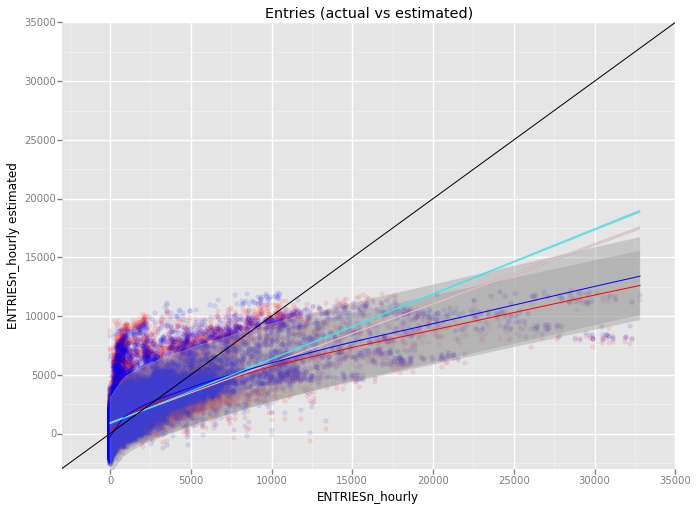

<ggplot: (339971037)>

In [203]:
df_final = turnstile_weather
df_final['gd'] = gd_df
df_final['ols'] = ols_df
ggplot(df_final, aes(x='ENTRIESn_hourly', y='gd')) + geom_point(color='red', alpha=0.1) +\
    stat_smooth(color='red') +\
    stat_smooth(color='pink', method='lm') +\
    geom_point(df_final, aes(x='ENTRIESn_hourly', y='ols'), color='blue', alpha=0.1) +\
    stat_smooth(df_final, aes(x='ENTRIESn_hourly', y='ols'), color='blue') +\
    stat_smooth(df_final, aes(x='ENTRIESn_hourly', y='ols'), color='aqua', method='lm') +\
    geom_abline() +\
    xlim(-3000, 35000) +\
    ylim(-3000, 35000) +\
    ylab('ENTRIESn_hourly estimated') +\
    ggtitle('Entries (actual vs estimated)')

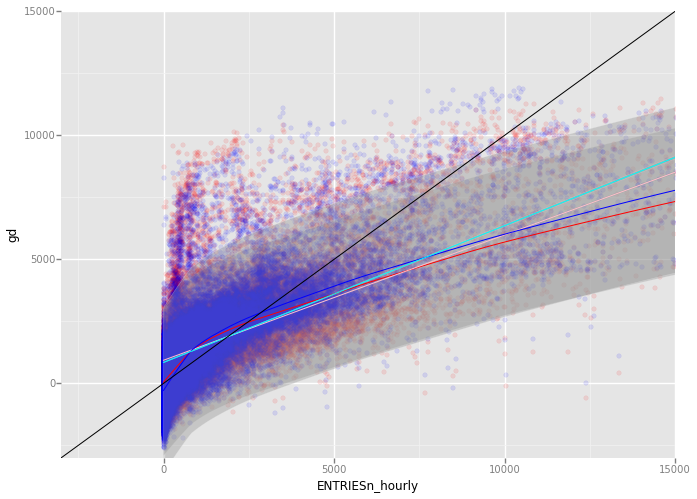

<ggplot: (293844781)>

In [169]:
df_final = turnstile_weather
df_final['gd'] = gd_df
df_final['ols'] = ols_df
ggplot(df_final, aes(x='ENTRIESn_hourly', y='gd')) + geom_point(color='red', alpha=0.1) +\
    stat_smooth(color='red') +\
    stat_smooth(color='pink', method='lm') +\
    geom_point(df_final, aes(x='ENTRIESn_hourly', y='ols'), color='blue', alpha=0.1) +\
    stat_smooth(df_final, aes(x='ENTRIESn_hourly', y='ols'), color='blue') +\
    stat_smooth(df_final, aes(x='ENTRIESn_hourly', y='ols'), color='aqua', method='lm') +\
    geom_abline() +\
    xlim(-3000, 15000) +\
    ylim(-3000, 15000)

In [199]:
theta_ols[:10]

array([   91.81604036,   251.60958223,    54.26412209,     5.15990429,
        -844.41927264, -4433.78226047,    19.50560816,   -47.41895306,
           7.79552114,  -381.63655189])

In [201]:
theta_ols[-44:]

array([ -5.13371030e+01,  -8.48858638e+01,   2.43511841e+01,
        -2.44115321e+00,   1.05644031e-01,  -1.67913677e-03,
        -1.07601557e+03,  -2.49645994e+02,  -7.65339325e+01,
         6.63667953e+00,   1.53174242e+01,   8.63876977e+00,
        -5.10069717e+01,   1.14121069e+01,  -1.84865398e+00,
         2.37053963e-01,  -1.86161864e-02,   8.07465475e-04,
        -1.78341838e-05,   1.56831062e-07,   4.98824513e+01,
         1.68135796e+01,  -1.22910788e+01,  -1.62929551e+01,
         9.61846145e+00,  -1.40679451e+00,  -2.82037026e-02,
         1.27466191e-02,   1.42505748e+02,  -7.28049102e+01,
        -3.63362764e-01,   2.44293778e-01,  -5.23382498e-03,
         2.81001114e+01,  -8.32763244e-01,   9.18182005e-03,
        -3.59854775e-05,   2.57483634e+02,  -7.23596531e+01,
         1.12261615e+01,  -1.02458131e+00,   5.42489061e-02,
        -1.52988140e-03,   1.76633365e-05])

In [200]:
theta_gradient_descent[:9]

array([-542.71722881,  322.63530129,  342.32893856,  -58.49111695,
       -140.82706884,   51.36597415,   30.10696678,  343.47128938,
          3.62263884])

In [190]:
theta_gradient_descent[-52:]

array([  1.27720248e+02,   3.06117374e+01,  -1.03340198e+02,
         1.98830793e+00,  -6.48187210e+00,   2.35417445e+01,
         1.26482710e+01,   1.24268993e+03,   6.20334558e+02,
         1.09041673e+01,  -2.57388604e+02,  -2.55293501e+02,
        -9.65694284e+01,   1.47137430e+01,   4.06640005e+01,
         2.43737874e+01,   1.30832432e+00,  -1.42859291e+01,
        -2.12806614e+01,   6.47689079e+01,  -3.49599376e+01,
        -1.00624812e+02,  -1.26464597e+02,  -1.17440996e+02,
        -8.04617865e+01,  -2.15468221e+01,   5.44928849e+01,
        -6.84587894e+01,  -1.03936423e+02,  -8.65900473e+01,
        -6.29224974e+01,  -4.02318961e+01,  -1.96130787e+01,
        -1.20568212e+00,   1.50239022e+01,   3.88194496e+01,
         2.63141618e+01,   1.38504136e+01,   1.42849987e+00,
        -1.09512932e+01,   2.10531587e+02,   7.32709404e+01,
        -6.63587336e+01,  -2.06646241e+02,   2.67704980e+02,
         6.94596602e+01,  -1.00520133e+02,  -1.56865764e+02,
        -1.17679365e+02,

# Let's check an individual station

In [683]:
selected_station = 'MAIN ST'
station = turnstile_weather[turnstile_weather.station == selected_station].reset_index()

In [684]:
# Select Features (try different features!)
features_station = station[['hour', 'day_week', 'weekday', 'fog', 'precipi', 'pressurei', 'rain', 'tempi', 'wspdi']]

# Add UNIT to features using dummy variables
dummy_units = pd.get_dummies(station['conds'], prefix='cond')
features_station = features_station.join(dummy_units)

for i in xrange(2, 8):
    value_pow = np.power(station.hour, i)
    tag = 'hour' + str(i)
    features_station[tag] = value_pow
    
for i in xrange(2, 8):
    value_pow = np.power(station.precipi, i)
    tag = 'precipi' + str(i)
    features_station[tag] = value_pow
    
for i in xrange(2, 10):
    value_pow = np.power(station.DAYn, i)
    tag = 'DAYn' + str(i)
    features_station[tag] = value_pow
    
for i in xrange(2, 10):
    value_pow = np.power(station.day_week, i)
    tag = 'day_week' + str(i)
    features_station[tag] = value_pow
    
for i in xrange(2, 7):
    value_pow = np.power(station.pressurei, i)
    tag = 'pressurei' + str(i)
    features_station[tag] = value_pow
    
for i in xrange(2, 6):
    value_pow = np.power(station.tempi, i)
    tag = 'tempi' + str(i)
    features_station[tag] = value_pow
    
for i in xrange(2, 9):
    value_pow = np.power(station.wspdi, i)
    tag = 'wspdi' + str(i)
    features_station[tag] = value_pow

values_station = station['ENTRIESn_hourly']

# Convert features and values to numpy arrays
features_array_station = np.array(features_station)
values_array_station = np.array(values_station)

fit_station = ols_function(values_array_station, features_array_station)
theta_ols_station = fit_station.params

predictions_ols_station = np.dot(sm.add_constant(features_array_station), theta_ols_station)

fit_station.rsquared

0.78281610830256088

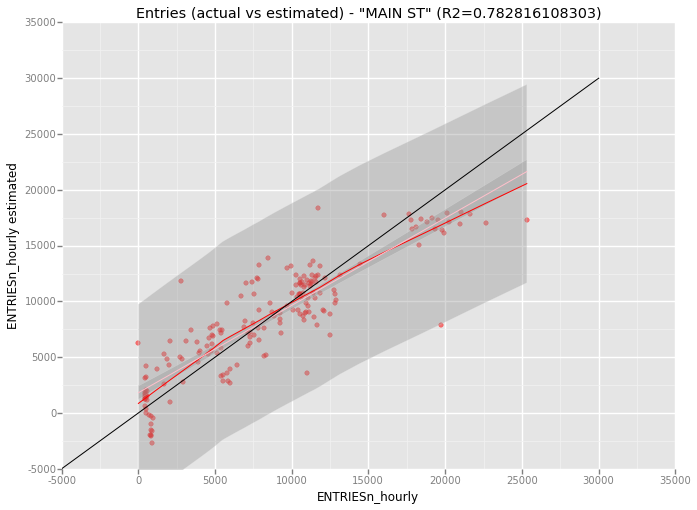

<ggplot: (375587537)>

In [685]:
ols_df_station = pd.DataFrame(predictions_ols_station)
df_final_station = station
df_final_station['ols'] = ols_df_station
ggplot(df_final_station, aes(x='ENTRIESn_hourly', y='ols')) + geom_point(color='red', alpha=0.5) +\
    stat_smooth(color='red') +\
    stat_smooth(color='pink', method='lm') +\
    geom_abline() +\
    xlim(-5000, 35000) +\
    ylim(-5000, 35000) +\
    ylab('ENTRIESn_hourly estimated') +\
    ggtitle('Entries (actual vs estimated) - ' + '"' + selected_station + '" (R2=' + str(fit_station.rsquared) + ')')

In [686]:
len(station)

186

In [687]:
new_group_mean = turnstile_weather.groupby('station').count().sort('UNIT', ascending=False)
new_group_mean

,UNIT,DATEn,TIMEn,ENTRIESn,EXITSn,ENTRIESn_hourly,EXITSn_hourly,datetime,hour,day_week,...,wspdi,meanprecipi,meanpressurei,meantempi,meanwspdi,weather_lat,weather_lon,DAYn,gd,ols
station,,,,,,,,,,,,,,,,,,,,,
34 ST-PENN STA,558,558,558,558,558,558,558,558,558,558,...,558,558,558,558,558,558,558,558,558,558
86 ST,551,551,551,551,551,551,551,551,551,551,...,551,551,551,551,551,551,551,551,551,551
LEXINGTON AVE,549,549,549,549,549,549,549,549,549,549,...,549,549,549,549,549,549,549,549,549,549
50 ST,539,539,539,539,539,539,539,539,539,539,...,539,539,539,539,539,539,539,539,539,539
145 ST,518,518,518,518,518,518,518,518,518,518,...,518,518,518,518,518,518,518,518,518,518
CHURCH AVE,372,372,372,372,372,372,372,372,372,372,...,372,372,372,372,372,372,372,372,372,372
CHAMBERS ST,372,372,372,372,372,372,372,372,372,372,...,372,372,372,372,372,372,372,372,372,372
34 ST-HERALD SQ,372,372,372,372,372,372,372,372,372,372,...,372,372,372,372,372,372,372,372,372,372
WALL ST,372,372,372,372,372,372,372,372,372,372,...,372,372,372,372,372,372,372,372,372,372


# Analysis of residual's distribution

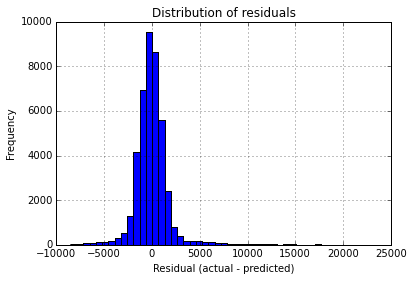

In [688]:
error = turnstile_weather.ENTRIESn_hourly - predictions_ols
plt.figure()
error.hist(bins=50)
plt.title('Distribution of residuals')
plt.xlabel('Residual (actual - predicted)')
plt.ylabel('Frequency')
plt.show()

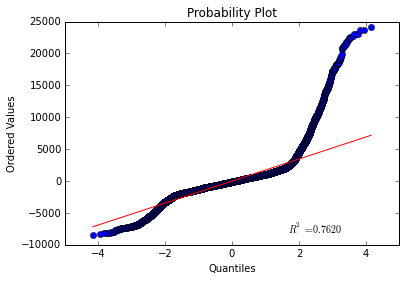

In [689]:
st.probplot(error, plot=plt)
plt.title('Probability Plot')
plt.show()

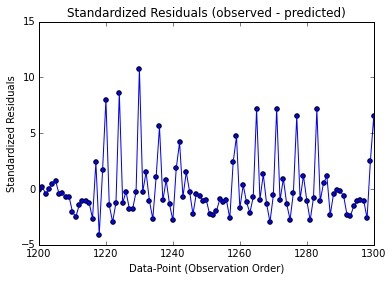

In [690]:
error_s = (error - error.mean())/error.std() # standardized residuals (http://docs.statwing.com/interpreting-residual-plots-to-improve-your-regression/)

plt.figure()
#plt.scatter(error_s.index, error_s, edgecolors='none', alpha=0.05)
plt.scatter(error_s.index, error_s)
plt.plot(error_s.index, error_s)
#plt.xlim(0, 42649)
plt.xlim(1200, 1300)
plt.ylim(-5, 15)
plt.title('Standardized Residuals (observed - predicted)')
plt.xlabel('Data-Point (Observation Order)')
plt.ylabel('Standardized Residuals')

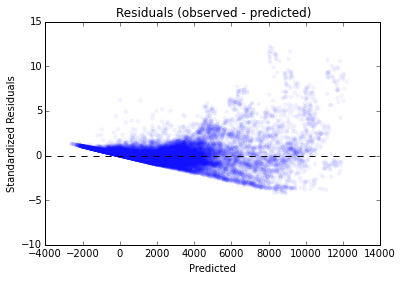

In [691]:
plt.figure()
plt.scatter(predictions_ols, error_s, edgecolors='none', alpha=0.05)
plt.title('Residuals (observed - predicted)')
plt.xlabel('Predicted')
plt.ylabel('Standardized Residuals')
plt.axhline(color='black', linestyle='--')

# Analysis of residual's distribution of individual stations

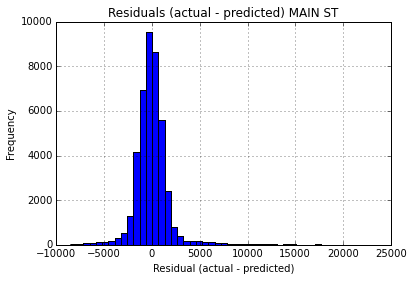

In [692]:
error_station = station.ENTRIESn_hourly - predictions_ols_station
plt.figure()
error.hist(bins=50)
plt.title('Residuals (actual - predicted) ' + selected_station)
plt.xlabel('Residual (actual - predicted)')
plt.ylabel('Frequency')
plt.show()

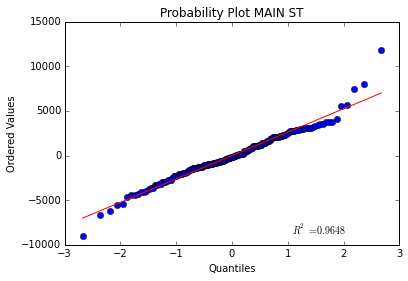

In [693]:
st.probplot(error_station, plot=plt)
plt.title('Probability Plot ' + selected_station)
plt.show()

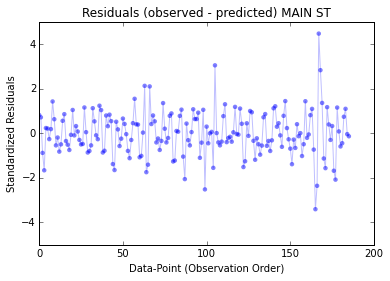

In [694]:
error_s_station = (error_station - error_station.mean())/error_station.std() # standardized residuals (http://docs.statwing.com/interpreting-residual-plots-to-improve-your-regression/)

plt.figure()
plt.scatter(error_s_station.index, error_s_station, edgecolors='none', alpha=0.5)
#plt.scatter(error_s_station.index, error_s_station)
plt.plot(error_s_station.index, error_s_station, alpha=0.25)
plt.xlim(0, 200)
plt.ylim(-5, 5)
plt.title('Residuals (observed - predicted) ' + selected_station)
plt.xlabel('Data-Point (Observation Order)')
plt.ylabel('Standardized Residuals')

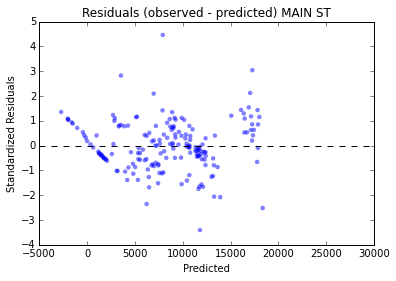

In [695]:
plt.figure()
plt.scatter(predictions_ols_station, error_s_station, edgecolors='none', alpha=0.5)
plt.title('Residuals (observed - predicted) ' + selected_station)
plt.xlabel('Predicted')
plt.ylabel('Standardized Residuals')
plt.ylim(-4, 5)
plt.xlim(-5000, 30000)
plt.axhline(color='black', linestyle='--')

In [696]:
predictions_ols_station.max()

18360.84381633997

In [697]:
predictions_ols_station.min()

-2708.659744232893